# OCRovai App using Python Tesseract OCR
https://github.com/madmaze/pytesseract

<img src="./images/OCRovai_logo_fundo.png"/>
Developed by MJ Rovai @ June, 1 2020<br>

Python-tesseract is an optical character recognition (OCR) tool for python. That is, it will recognize and "read" the text embedded in images.

Python-tesseract is a wrapper for Google's Tesseract-OCR Engine. It is also useful as a stand-alone invocation script to tesseract, as it can read all image types supported by the Pillow and Leptonica imaging libraries, including jpeg, png, gif, bmp, tiff, and others. Additionally, if used as a script, Python-tesseract will print the recognized text instead of writing it to a file.

**Tutorial:**
- [A comprehensive guide to OCR with Tesseract, OpenCV and Python](https://nanonets.com/blog/ocr-with-tesseract/)
- [PyTesseract: Simple Python Optical Character Recognition - App Flask](https://stackabuse.com/pytesseract-simple-python-optical-character-recognition/)

## Import Libraries and setup

In [9]:
from flask import Flask, request, render_template
import pyperclip
import os
import numpy as np
from PIL import Image
import cv2
import pytesseract
import matplotlib.pyplot as plt

## Possible OpenCV filters - Test

In [72]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

## Check Pytesseract available languages

In [30]:
!tesseract --list-langs

List of available languages (162):
afr
amh
ara
asm
aze
aze_cyrl
bel
ben
bod
bos
bre
bul
cat
ceb
ces
chi_sim
chi_sim_vert
chi_tra
chi_tra_vert
chr
cos
cym
dan
deu
div
dzo
ell
eng
enm
epo
est
eus
fao
fas
fil
fin
fra
frk
frm
fry
gla
gle
glg
grc
guj
hat
heb
hin
hrv
hun
hye
iku
ind
isl
ita
ita_old
jav
jpn
jpn_vert
kan
kat
kat_old
kaz
khm
kir
kmr
kor
kor_vert
lao
lat
lav
lit
ltz
mal
mar
mkd
mlt
mon
mri
msa
mya
nep
nld
nor
oci
ori
osd
pan
pol
por
pus
que
ron
rus
san
script/Arabic
script/Armenian
script/Bengali
script/Canadian_Aboriginal
script/Cherokee
script/Cyrillic
script/Devanagari
script/Ethiopic
script/Fraktur
script/Georgian
script/Greek
script/Gujarati
script/Gurmukhi
script/HanS
script/HanS_vert
script/HanT
script/HanT_vert
script/Hangul
script/Hangul_vert
script/Hebrew
script/Japanese
script/Japanese_vert
script/Kannada
script/Khmer
script/Lao
script/Latin
script/Malayalam
script/Myanmar
script/Oriya
script/Sinhala
script/Syriac
script/Tamil
script/Telugu
script/Thaana
script/Thai
s

## Support Functions

In [23]:
# Faster but not working Heroku
def filter_img_openCV(imagem):
    imagem = imagem.convert('RGB')
    npimagem = np.asarray(imagem).astype(np.uint8)
    npimagem[:, :, 0] = 0 # zerando o canal R (RED)
    npimagem[:, :, 2] = 0 # zerando o canal B (BLUE)
    im = cv2.cvtColor(npimagem, cv2.COLOR_RGB2GRAY)
    ret, thresh = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img = Image.fromarray(thresh)
    return img

In [58]:
def filter_img(img):
    img = binarize_image(img, threshold=127)
    return img

In [59]:
def binarize_array(np_array, threshold):
    """Binarize a np array."""
    up = np_array > threshold
    new_arr = np.zeros_like(np_array)
    new_arr[up] = 255
    return new_arr

In [36]:
# Very slow
def binarize_array_2(np_array, threshold):
    """Binarize a np array."""
    for i in range(len(np_array)):
        for j in range(len(np_array[0])):
            if np_array[i][j] > threshold:
                np_array[i][j] = 255
            else:
                np_array[i][j] = 0
    return np_array

In [3]:
def ocr_image(imagePath, filename, filter, lang):
    img = Image.open(imagePath)
    if filter == 'on':
        img = filter_img(img)
    img.save('./images/input_image.png')
    try:
        txt = pytesseract.image_to_string(img, lang=lang)
        prediction = "SUCCESS"
    except:
        txt = " pytesseract did not work properly with language: "+lang
        prediction = "FAILURE"
    txt_name = filename.split('.')[0]
    txt_path = './text/recognized_text.txt'
    with open(txt_path, 'w') as f:
        f.write(txt)

    with open(txt_path, 'r') as f:
        content = f.readlines()

    cont = ''.join(content)
    pyperclip.copy(cont)
    #os.remove(imagePath)
    return prediction, content

In [21]:
def get_ocr(img_path, img_file, filter='on', lang='eng', show_image=True):
    imagePath = img_path+img_file
    prediction, content = ocr_image(imagePath, img_file, filter, lang)
    if show_image:
        plt.figure(figsize = (10,10))
        img = Image.open('./images/input_image.png')
        plt.imshow(img)
        plt.show() 
    return prediction, content

In [53]:
!pwd

/Users/mjrovai/Dropbox/2020/10_Data_Science/50_Computer_Vision/OCR


In [5]:
!ls ./images/

447_photo.jpg          452_photo.jpg          IMG_351.JPG
447_photo_2.jpg        464.jpg                IMG_4.jpg
448_photo.jpg          464_2.jpg              OCRovai.png
448_photo.pdf          464_3.jpg              OCRovai_Logo_fundo.png
449_photo.jpg          464_4.jpg              input_image.png
450.jpg                IMG_1.jpg              suecia.JPG
450_photo.jpg          IMG_2.jpg
451_photo.jpg          IMG_3.jpg


In [6]:
img_path = './images/'

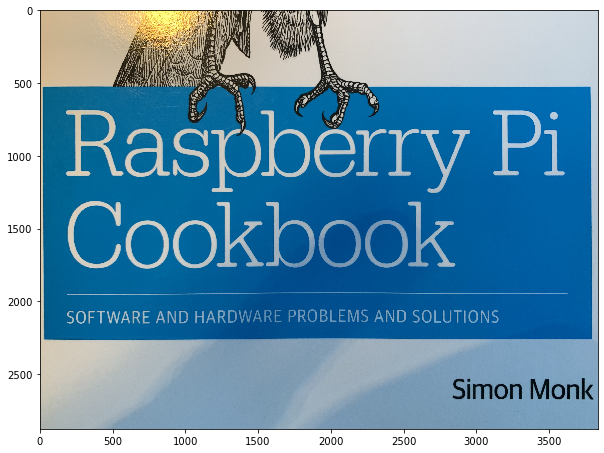

Simon Monk


In [56]:
img_file = 'IMG_3.jpg'
prediction, content = get_ocr(img_path, img_file, filter='off', lang='eng')
print(pyperclip.paste())

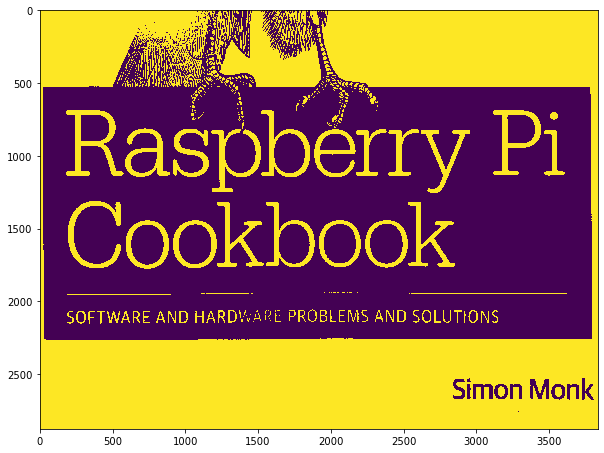

eae
7
7
a
aay
Aan 2
oe ,
4 _
5 ‘ 4
: x

Cookbook

SOFTWARE AND HARDWARE PROBLEMS AND SOLUTIONS

Simon Monk


In [60]:
img_file = 'IMG_3.jpg'
prediction, content = get_ocr(img_path, img_file, filter='on', lang='eng')
print(pyperclip.paste())

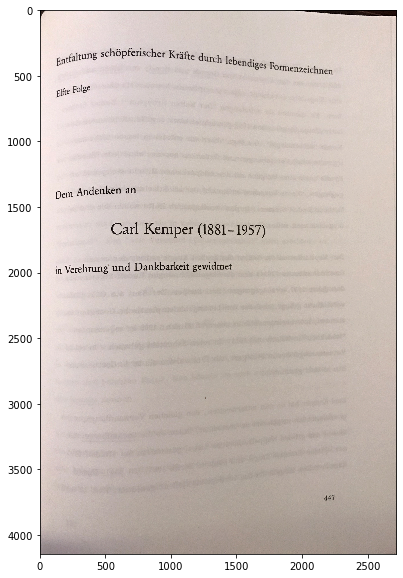

In [47]:
img_file = '447_photo.jpg'
prediction, content = get_ocr(img_path, img_file, filter='off', lang='deu')
print(pyperclip.paste())

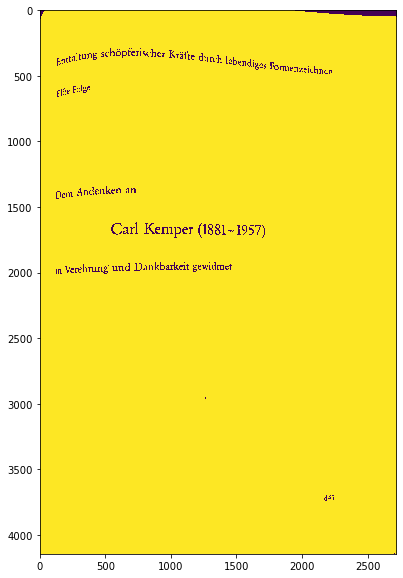

_ hö . n
Entfaltung °° Öpferischer Kräfte durch lebend
en iges For
menzeichnen

gifte Folge

Dem Andenken an

Carl Kemper (1881-1957)

in Verehrung und Dankbarkeit gewidmet

447


In [52]:
img_file = '447_photo.jpg'
prediction, content = get_ocr(img_path, img_file, filter='on', lang='deu')
print(pyperclip.paste())

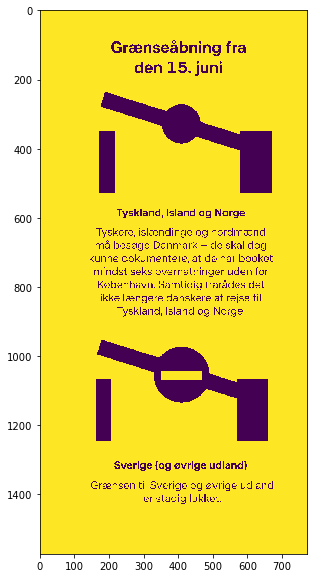

Grænseåbning fra
den 15. juni

Tyskland, Island og Norge

Tyskere, islændinge og nordmænd
må besøge Danmark - de skal dog
kunne dokumentere, at de har booket
mindst seks overnatninger uden for
København. Samtidig frarådes det
ikke længere danskere at rejse til
Tyskland, Island og Norge.

Sverige (og øvrige udland)

Grænsen til Sverige og øvrige udland
er stadig lukket.


In [39]:
img_file = 'suecia.JPG'
prediction, content = get_ocr(img_path, img_file, filter='on', lang='dan')
print(pyperclip.paste())